In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt

from pprint import pprint

import plotly.express as px
import plotly
import plotly.io as pio
import plotly.graph_objects as go

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

### Load Dataset

In [3]:
dataset = 'survey_report_combined.csv'
df = pd.read_csv(dataset, dtype=object)
df['year'] = pd.to_datetime(df['year'], format='%Y')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412186 entries, 0 to 412185
Data columns (total 19 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   year                                        412186 non-null  datetime64[ns]
 1   original_missing_values_per_row_percentage  412186 non-null  object        
 2   country                                     409905 non-null  object        
 3   programming_languages                       353322 non-null  object        
 4   programming_languages_other                 6955 non-null    object        
 5   years_experience                            390424 non-null  object        
 6   occupation                                  387781 non-null  object        
 7   age                                         295531 non-null  object        
 8   os                                          311465 non-null  object       

In [4]:
df.head()

,year,original_missing_values_per_row_percentage,country,programming_languages,programming_languages_other,years_experience,occupation,age,os,job_satisfaction,company_size,want_work_language,gender,education,database_desire_work,database_worked_with,undergrad_major,remote_status,industry
0,2011-01-01,18.18,Africa,javascript,NaN,<2,Web Application Developer,< 20,Linux,FML,1-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Consulting
1,2011-01-01,27.27,Other Europe,java;sql;c,NaN,41310,Server Programmer,25-29,Windows 7,So happy it hurts,25-100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Software Products
2,2011-01-01,45.45,India,java;javascript;sql,NaN,41435,Server Programmer,25-29,Linux,NaN,100-999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Software Products
3,2011-01-01,9.09,Germany,java,haskell,41310,Student,< 20,Linux,I enjoy going to work,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Foundation / Non-Profit
4,2011-01-01,13.64,Other Asia,java;javascript;css;php;sql;c++;c;perl,NaN,11,"Executive (VP of Eng., CTO, CIO, etc.)",35-39,Linux,It pays the bills,1-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Software Products


### Exploding programming languages feature
Two columns: `programming_languages` and `programming_languages_other`

In [5]:
df['programming_languages']       = df.programming_languages.str.lower().str.split('/|;')
df['programming_languages_other'] = df.programming_languages_other.str.lower().str.split('/|;')

In [6]:
df_explode = df.explode('programming_languages')
df_explode['programming_languages'] = df_explode.programming_languages.str.strip()

In [7]:
df_explode = df_explode.explode('programming_languages_other')
df_explode['programming_languages_other'] = df_explode.programming_languages_other.str.strip()

In [8]:
df_explode.loc[df_explode.programming_languages.str.startswith('cloud', na=False), 'programming_languages'] = 'cloud'

In [9]:
df_explode.head()

,year,original_missing_values_per_row_percentage,country,programming_languages,programming_languages_other,years_experience,occupation,age,os,job_satisfaction,company_size,want_work_language,gender,education,database_desire_work,database_worked_with,undergrad_major,remote_status,industry
0,2011-01-01,18.18,Africa,javascript,NaN,<2,Web Application Developer,< 20,Linux,FML,1-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Consulting
1,2011-01-01,27.27,Other Europe,java,NaN,41310,Server Programmer,25-29,Windows 7,So happy it hurts,25-100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Software Products
1,2011-01-01,27.27,Other Europe,sql,NaN,41310,Server Programmer,25-29,Windows 7,So happy it hurts,25-100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Software Products
1,2011-01-01,27.27,Other Europe,c,NaN,41310,Server Programmer,25-29,Windows 7,So happy it hurts,25-100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Software Products
2,2011-01-01,45.45,India,java,NaN,41435,Server Programmer,25-29,Linux,NaN,100-999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Software Products


In [10]:
df_explode.shape

(2060544, 19)

### Languages and technologies labeling

In [11]:
from tech_labeling import tech_labeling 

In [12]:
df_explode['tech_type'] = df_explode.programming_languages.map(lambda x: tech_labeling.get(x, ''))

### JS related technology

In [46]:
js_langs = df_explode[df_explode.programming_languages_other.str.endswith('js', na=False)]

In [167]:
js_langs_year = js_langs.groupby(['year', 'programming_languages_other']).programming_languages_other.count().to_frame()
js_langs_year['percentage'] = js_langs_year.groupby(level=0).apply(lambda x: x / float(x.sum())).round(4)

js_langs_year.index.names = ['Year','Language']
js_langs_year.columns = ['Count', 'Percentage']
display(js_langs_year.head())

js_langs_year.reset_index(inplace=True)
js_langs_year.Year = js_langs_year.Year.dt.year.astype(str)
js_langs_year.sort_values(['Year', 'Count'], ascending=True, inplace=True)
js_langs_year.Language = js_langs_year.Language.str.split().str[0].str.title()

Count  Percentage
Year       Language                      
2012-01-01 four js          3      0.0938
           node js         29      0.9062
2013-01-01 angular js      40      0.1794
           backbone js     41      0.1839
           d3 js           10      0.0448

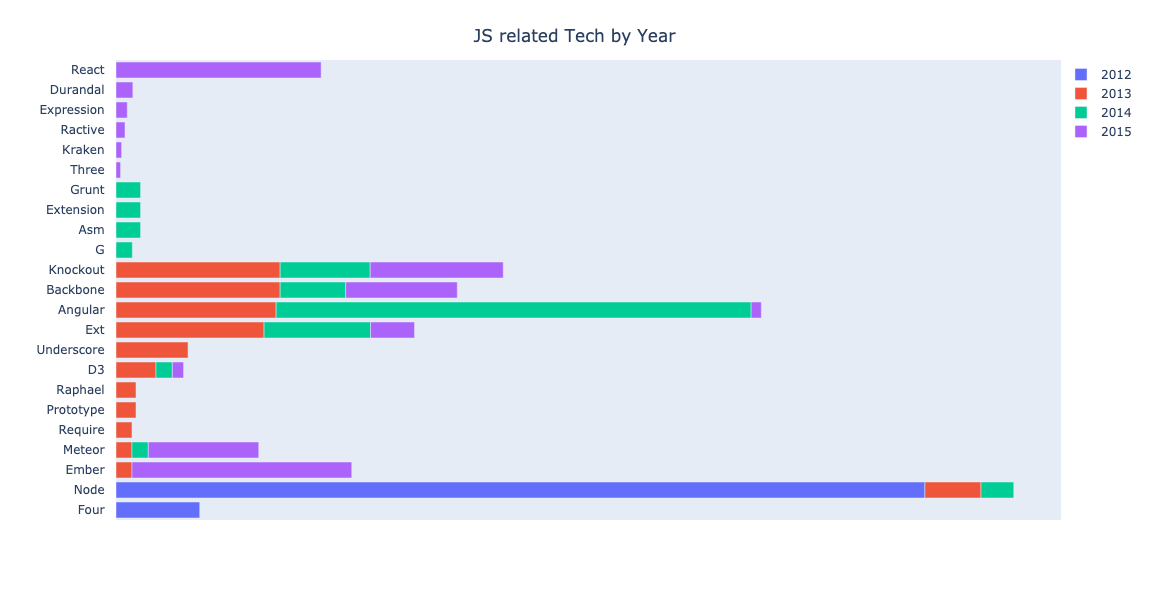

In [168]:
fig = px.bar(
    js_langs_year, y="Language", x="Percentage",
    color='Year', 
    orientation='h',
    height=600,
    hover_name="Language", 
    hover_data={
        'Language':False, # remove species from hover data
        'Percentage':':.2%', # customize hover for column of y attribute
    }
)

fig.update_layout(
    legend=dict(
        title='',
        y=1, x=1
    ),
    xaxis={'visible': False},
    yaxis={'title': '', 'ticks': "outside", 'tickcolor':'white', 'ticklen':8},
    title={
        'text': "JS related Tech by Year",
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    hoverlabel = dict(
        font=dict(color='white')
    )
)

fig.show()

### Common languages evolution

In [166]:
langs_year = df_explode[df_explode.tech_type=='language'].groupby(['year', 'programming_languages']).agg({'programming_languages': 'count'})
langs_year['Percentage'] = langs_year.groupby(level=0).programming_languages.apply(lambda x: x / float(x.sum())).round(4)
langs_year.columns = ['Count', 'Percentage']
display(langs_year.head())

langs_year.index.names = ['Year','Language']
langs_year.reset_index(inplace=True)
langs_year.sort_values(['Year', 'Count'], ascending=True, inplace=True)

Count  Percentage
year       programming_languages                   
2011-01-01 c                        830      0.0759
           c#                      1464      0.1338
           c++                      813      0.0743
           css                     1486      0.1358
           java                     926      0.0847

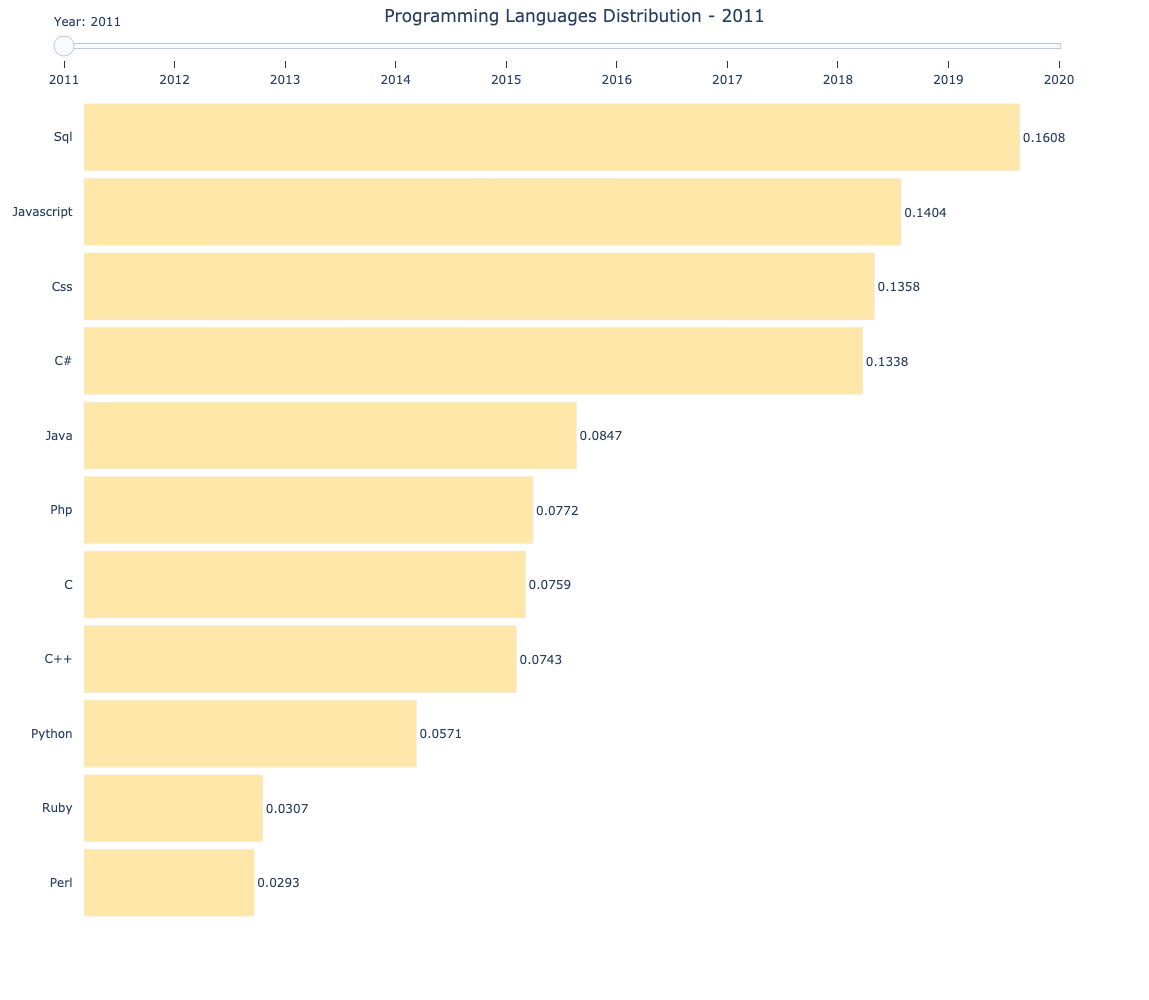

In [170]:
dataset_years = list(range(2011,2021))

dfs = {}
for year in dataset_years:
    dfs[year] = langs_year[langs_year['Year'].dt.year==year]

start_index = 0

data=[
    go.Bar(
        x=dfs[year]['Count'], 
        y=dfs[year]['Language'].str.title(), 
        orientation='h',
        text=dfs[year]['Percentage'],
        textfont={'size':12}, 
        textposition='outside', 
        insidetextanchor='end',
        visible = False,
        width=0.9,
        name=str(year),
        marker=dict(
            color='rgb(255, 231, 169)'
        ),
        hovertemplate =
            '<b>%{y}</b><br><br>'+
            'Count: %{x:.d} <br>'+ # https://github.com/d3/d3-format
            'Percentage: %{text:.2%}<br>'+
            "<extra></extra>"
    )
    for year in dataset_years
]

data[start_index]['visible'] = True


steps = []
for i in range(len(data)):
    year = (i+2011)
    step = dict(
        # Update method allows us to update both trace and layout properties
        method = 'update',  
        args = [
            # Make the ith trace visible
            {'visible': [t == i for t in range(len(data))]},
            
            # Set the title for the ith trace
            {'title.text': 'Programming Languages Distribution - %d' % year},
            
            {
                "frame": {"duration": 300, "redraw": False},
                 "mode": "immediate",
                 "transition": {"duration": 300}
            }
        ],
        label=year
    )
    steps.append(step)
    
sliders = [go.layout.Slider(
    active = 0,
    currentvalue = {"prefix": "Year: "},
    transition={"duration": 300, "easing": "cubic-in-out"},
    pad = {"b": 10, "t": -910, 'l': -30},
    steps = steps,
)]

layout = go.Layout(
    sliders=sliders,
    height=1000,
    title={
        'text': "Programming Languages Distribution - 2011",
        'x':0.5,
        'y':0.99,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    plot_bgcolor='rgba(0,0,0,0)',
    xaxis={'visible': False,  'tickformat': "digit" },
    yaxis={'ticks': "outside", 'tickcolor':'white', 'ticklen':8},
)

fig = go.Figure(data=data, layout=layout)

fig.show()